<a href="https://colab.research.google.com/github/cbsobral/ml-fies/blob/main/Module_2b_Logistic_Tuning_and_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 01 - Models

In this module, we perform the following steps:

1. Load the data from Mod_00 and create sets and targets for train and test datasets;
2. Standardize and encode observations;
3. Run preliminary models;
4. Provide performance measures and visualization. 

In [ ]:
pd.DataFrame(train_prepared).to_csv("/content/drive/MyDrive/M/Machine Learning/Data.Base/train_prepared.csv")

### 1 - Load Data

Here, we import the training and testing sets created in Module00_Data. 


In [3]:
import pandas as pd

url_train = "https://drive.google.com/file/d/1IP7jyXkLgD_Ouy5cL6fJk4VUA5qRB2PK/view?usp=sharing"
path_train = "https://drive.google.com/uc?export=download&id="+url_train.split("/")[-2]
train = pd.read_csv(path_train)
train.shape

(351001, 31)

In [4]:
url_test = "https://drive.google.com/file/d/1v4FqKwt7NzG5RM6d9f1y7CLIdKq69jSS/view?usp=sharing"
path_test = "https://drive.google.com/uc?export=download&id="+url_test.split("/")[-2]
test = pd.read_csv(path_test)
test.shape

(87751, 31)

In [5]:
train_set = train.drop("default", axis=1) # drop targets for training set
train_target = train["default"].copy()

In [6]:
test_set = test.drop("default", axis=1) # drop targets for test set
test_target = test["default"].copy()

### 2 - Pipeline

The pipeline contains functions that will be used to transform the dataset. For the numeric attributes, the stardardization is performed by the StandardScaler. For ordinal attributes, variables are encoded by the OrdinalEncoder, and for categorical, theOneHotEncoder. 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("num_imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

ord_pipeline = Pipeline([
        ("ord_imputer", SimpleImputer(strategy="most_frequent")),
        ("ord_encoder", OrdinalEncoder()),
    ])

In [9]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

In [10]:
ord_attribs = ["igc","date_contract"] # 2 attributes

num_attribs = ["family_income",   #17
               "personal_income",
               "high_school_endyear",
               "n_sem_course",
               "n_completed_sem",
               "sem_funded",
               "fam_size",
               "income_pc",
               "tuition_current",
               "inc_prop",
               "perc_requested",
               "loan_value_sem",
               "student_resource",
               "loan_value",
               "loan_limit",
               "total_debt",
               "age"]
  

cat_attribs = ["semester_enroll",  #9
               "gender",
               "occupation", 
               "marital_status",
               "ethnicity", 
               "public_hs", 
               "state_course", 
               "degree", 
               "contract_phase"]

In [11]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("ord", ord_pipeline, ord_attribs)
        ])

In [12]:
train_prepared = full_pipeline.fit_transform(train_set)
train_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [13]:
test_prepared = full_pipeline.fit_transform(test_set)
test_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

## 2 - Sampling 

In [38]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

train_over, target_train_over_over = os.fit_resample(train_prepared, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [39]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
train_under, target_under = rus.fit_resample(train_prepared, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 3 - Classifiers

For the initial runs, we employ 5 methods: logistic regression, decision tree, random forest, linear support vector classification (SVC), and artificial neural networks (ANN). 


In [16]:
#Randomsearch normal_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,1100,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [ ]:
LR_search = RandomizedSearchCV(LR,param_distributions=LRparam_grid,refit = True,scoring="roc_auc",verbose = 3, cv=5, random_state=42 )
# fitting the model for grid search 
LR_search.fit(train_prepared ,train_target)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] solver=sag, penalty=l2, max_iter=600, C=0.01 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV]  solver=sag, penalty=l2, max_iter=600, C=0.01, score=0.724, total= 2.6min
[CV] solver=sag, penalty=l2, max_iter=600, C=0.01 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s


[CV]  solver=sag, penalty=l2, max_iter=600, C=0.01, score=0.718, total= 2.4min
[CV] solver=sag, penalty=l2, max_iter=600, C=0.01 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  solver=sag, penalty=l2, max_iter=600, C=0.01, score=0.720, total= 2.3min
[CV] solver=sag, penalty=l2, max_iter=600, C=0.01 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  solver=sag, penalty=l2, max_iter=600, C=0.01, score=0.723, total= 2.4min
[CV] solver=sag, penalty=l2, max_iter=600, C=0.01 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  solver=sag, penalty=l2, max_iter=600, C=0.01, score=0.720, total= 2.4min
[CV] solver=newton-cg, penalty=l1, max_iter=100, C=100 ...............
[CV]  solver=newton-cg, penalty=l1, max_iter=100, C=100, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=l1, max_iter=100, C=100 ...............
[CV]  solver=newton-cg, penalty=l1, max_iter=100, C=100, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=l1, max_iter=100, C=100 ...............
[CV]  solver=newton-cg, penalty=l1, max_iter=100, C=100, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=l1, max_iter=100, C=100 ...............
[CV]  solver=newton-cg, penalty=l1, max_iter=100, C=100, score=nan, total=   0.0s
[CV] solver=newton-cg, penalty=l1, max_iter=100, C=100 ...............
[CV]  solver=newton-cg, penalty=l1, max_iter=100, C=100, score=nan, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=1000, C=1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  solver=lbfgs, penalty=l2, max_iter=1000, C=1, score=0.726, total= 1.0min
[CV] solver=lbfgs, penalty=l2, max_iter=1000, C=1 ....................
[CV]  solver=lbfgs, penalty=l2, max_iter=1000, C=1, score=0.720, total=  53.1s
[CV] solver=lbfgs, penalty=l2, max_iter=1000, C=1 ....................
[CV]  solver=lbfgs, penalty=l2, max_iter=1000, C=1, score=0.722, total= 1.0min
[CV] solver=lbfgs, penalty=l2, max_iter=1000, C=1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  solver=lbfgs, penalty=l2, max_iter=1000, C=1, score=0.725, total= 1.0min
[CV] solver=lbfgs, penalty=l2, max_iter=1000, C=1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  solver=lbfgs, penalty=l2, max_iter=1000, C=1, score=0.722, total= 1.0min
[CV] solver=newton-cg, penalty=l2, max_iter=600, C=0.01 ..............
[CV]  solver=newton-cg, penalty=l2, max_iter=600, C=0.01, score=0.726, total=  25.4s
[CV] solver=newton-cg, penalty=l2, max_iter=600, C=0.01 ..............
[CV]  solver=newton-cg, penalty=l2, max_iter=600, C=0.01, score=0.720, total=  26.0s
[CV] solver=newton-cg, penalty=l2, max_iter=600, C=0.01 ..............
[CV]  solver=newton-cg, penalty=l2, max_iter=600, C=0.01, score=0.722, total=  26.6s
[CV] solver=newton-cg, penalty=l2, max_iter=600, C=0.01 ..............
[CV]  solver=newton-cg, penalty=l2, max_iter=600, C=0.01, score=0.725, total=  26.9s
[CV] solver=newton-cg, penalty=l2, max_iter=600, C=0.01 ..............
[CV]  solver=newton-cg, penalty=l2, max_iter=600, C=0.01, score=0.722, total=  31.1s
[CV] solver=lbfgs, penalty=l1, max_iter=300, C=1 .....................
[CV]  solver=lbfgs, penalty=l1, max_iter=300, C=1, score=nan, total=  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  solver=liblinear, penalty=l1, max_iter=200, C=0.1, score=0.727, total=  48.2s
[CV] solver=liblinear, penalty=l1, max_iter=200, C=0.1 ...............
[CV]  solver=liblinear, penalty=l1, max_iter=200, C=0.1, score=0.722, total=  51.5s
[CV] solver=liblinear, penalty=l1, max_iter=200, C=0.1 ...............
[CV]  solver=liblinear, penalty=l1, max_iter=200, C=0.1, score=0.723, total=  40.1s
[CV] solver=liblinear, penalty=l1, max_iter=200, C=0.1 ...............
[CV]  solver=liblinear, penalty=l1, max_iter=200, C=0.1, score=0.726, total=  44.1s
[CV] solver=liblinear, penalty=l1, max_iter=200, C=0.1 ...............
[CV]  solver=liblinear, penalty=l1, max_iter=200, C=0.1, score=0.723, total=  40.8s
[CV] solver=saga, penalty=l1, max_iter=400, C=0.1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  solver=saga, penalty=l1, max_iter=400, C=0.1, score=0.722, total= 3.0min
[CV] solver=saga, penalty=l1, max_iter=400, C=0.1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  solver=saga, penalty=l1, max_iter=400, C=0.1, score=0.716, total= 3.1min
[CV] solver=saga, penalty=l1, max_iter=400, C=0.1 ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  solver=saga, penalty=l1, max_iter=400, C=0.1, score=0.718, total= 3.1min
[CV] solver=saga, penalty=l1, max_iter=400, C=0.1 ....................


In [ ]:
LR_search_under = RandomizedSearchCV(LR,param_distributions=LRparam_grid,refit = True,scoring="roc_auc",verbose = 3, cv=5, random_state=42 )
# fitting the model for grid search 
LR_search_under.fit(train_under ,target_under)
LR_search_under.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search_under.best_score_)
print('Config: %s' % LR_search_under.best_params_)

In [ ]:

LR_search_over = RandomizedSearchCV(LR,param_distributions=LRparam_grid,refit = True,scoring="roc_auc",verbose = 3, cv=5, random_state=42 )
# fitting the model for grid search 
LR_search_over.fit(train_over ,target_over)
LR_search_over.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search_over.best_score_)
print('Config: %s' % LR_search_over.best_params_)

In [17]:

logr = LogisticRegression(max_iter=200, random_state=42,solver= 'liblinear', penalty= 'l1', C =0.1)

#### Getting the Trained data with names

This routine is necessary to get the feature importance and feature names

In [21]:
clf = Pipeline(steps=[('preprocessor', full_pipeline),
                      ('classifier', logr)])
clf.fit(train_set,train_target)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('num_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                         

In [27]:
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot'].get_feature_names(input_features=cat_attribs))


In [28]:
numeric_features_list = list(num_attribs)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(ord_attribs)

In [29]:
!pip install eli5

     |████████████████████████████████| 112kB 5.7MB/s 


In [31]:
import eli5
eli5.explain_weights(clf.named_steps['classifier'], top=50, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.582,semester_enroll_before 2012
+1.045,semester_enroll_12012
+0.782,state_course_AM
+0.630,state_course_AP
+0.482,semester_enroll_22012
+0.276,state_course_GO
+0.224,loan_value_sem
+0.200,degree_SERVIÇO SOCIAL
+0.199,state_course_RJ
+0.198,degree_EDUCAÇÃO FÍSICA


In [40]:
logr_under = LogisticRegression(random_state=42)
logr_under.fit(train_under, target_under)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
logr_over = LogisticRegression(random_state=42)
logr_over.fit(train_under, target_under)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Smote sampled logistics model

Score for the sampled dataset

#### Save the Models

In [ ]:
import joblib

file_name = '/content/drive/MyDrive/M/Machine Learning/Data.Base/logistitic_model_fies.save'
file_name_smote = '/content/drive/MyDrive/M/Machine Learning/Data.Base/logistitic_model_fies_smote.save'

joblib.dump(logr_optimized, file_name)
joblib.dump(logr_smote_optimized, file_name_smote)


['/content/drive/MyDrive/M/Machine Learning/Data.Base/logistitic_model_fies_smote.save']

#### Training Set

In [ ]:
# List with AUC scores for training set
cross_list = [cross_logr]
m1_list = ['Logistic Regression']

# Dataframe 
cross_df = pd.DataFrame({"Model": m1_list, "AUC": cross_list})
cross_df.sort_values(by = "AUC", ascending=False)

,Model,AUC
4,ANN,0.816213
2,Random Forest,0.775061
0,Logistic Regression,0.722902
3,Linear SVC,0.672063
1,Decision Tree,0.634598


#### Test Set

In this section, AUC and Brier scores were not calculated for the linear SVC model because it does not have a *predict_proba* function.


In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for test set
pred_logr = logr.predict_proba(test_prepared)
pred_logr_under= logr_under.predict_proba(test_prepared)
pred_logr_over= logr_over.predict_proba(test_prepared)



In [ ]:
from sklearn.metrics import brier_score_loss

loss_logr = brier_score_loss(test_target, pred_logr[:,1])
loss_logr_smote = brier_score_loss(test_target, pred_logr_smote[:,1])


In [ ]:
from sklearn.metrics import roc_auc_score

# AUC score
auc_logr = roc_auc_score(test_target, pred_logr[:,1])
auc_logr_under = roc_auc_score(test_target, pred_logr_under[:,1])
auc_logr_over = roc_auc_score(test_target, pred_logr_over[:,1])

In [ ]:
# List with AUC scores
auc_list = [auc_logr, auc_logr_under,auc_logr_over]

# List with Brier Scores
loss_list = auc_logr, auc_logr_under,auc_logr_over]

# List with model names
m2_list = ['Logistic Regression', 'Undersampled','Oversampled']

# Dataframe 
auc_df= pd.DataFrame({"Model": m2_list, "AUC": auc_list, "BS": loss_list})
auc_df.sort_values(by = "AUC", ascending=False)

,Model,AUC,BS
0,Logistic Regression,0.724568,0.724568
1,Logistic with SMOTE Sampling,0.722750,0.722750


The AUC results can be plotted, as shown bellow. 

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_logr, tpr_logr, thresh_logr = roc_curve(test_target, pred_logr[:,1], pos_label=1)
fpr_logr_smote, tpr_logr_smote, thresh_logr_smote = roc_curve(test_target, pred_logr_smote[:,1], pos_label=1)



# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

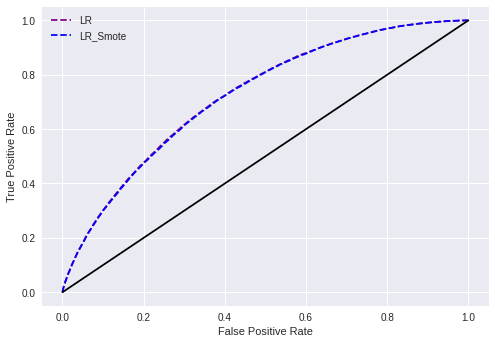

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

# plot roc curves
plt.plot(fpr_logr, tpr_logr, linestyle="--",color="purple", label="LR")
plt.plot(fpr_logr_smote, tpr_logr_smote, linestyle="--",color="blue", label="LR_Smote")
plt.plot(p_fpr, p_tpr, linestyle="-", color="black")

# x label
plt.xlabel("False Positive Rate")
# y label
plt.ylabel("True Positive Rate")

plt.legend(loc="best")
plt.savefig("ROC", dpi = 300)
plt.show()

In [ ]:
# Save Model Using joblib
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib


loaded_model = joblib.load('/content/drive/MyDrive/M/Machine Learning/Data.Base/logistitic_model_fies.save')

